In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks
import json
import math
from  helper import *
import datetime

---
# MUSIC for DOA estimation
##  Assignment 1 - Basic Implementation

### Introduction

#### Definitions

__MUSIC__ stands for Multiple Signal Classification and is an algorithm proposed by Schmidt and his colleagues in 1979

__DOA__ stands for Direction of Arrival

#### Goal

MUSIC can be used without modification for the estimation of DOA, assuming that there is a known number of sources and that the sources are uncorrelated. The goal of this mini-project is to compare a basic implementation of the MUSIC algorithm for DOA and an improved version, both for real/simulated and correlated/uncorrelated data.

#### Basic idea 

The basic idea of MUSIC algorithm is to conduct characteristic decomposition for the covariance matrix of any array output data, resulting in a __signal subspace__ orthogonal with a __noise subspace__ corresponding to the signal components. These two orthogonal subspaces are then used to constitute a __spectrum function__, put through a spectral peak search to detect DOA angles.

<img src="images/schema.png" alt="Schema" style="width: 400px;"/>

### Setup

#### Assumptions

- D narrowband source signals with identical center frequency
- Uniform Linear Array of M (M > D) isotropic microphones 
- Far-field
- Presence of Gaussian White Noise 
- Array element interval not larger than half the wavelength of the highest signal frequency


#### Parameters
Example of set up parameters used to generate the simulated signals to test our implementations of the MUSIC for DOA algorithm.

In [156]:
angles = [20., 60., -30., -35.]
freqs = [1/2, 1/3, 1/5, 1/10]

thetas = np.array(angles) / 180 * np.pi  # Incoming signal directions 
w = np.array(freqs)*2*np.pi              # Emitted frequencies corresponding to incoming signals
N = 200                                  # snapshots (number of samples)
M = 10                                   # number of receivers/mics
D = np.size(thetas)                      # number of sources
var = 0.10                               # variance of noise

We define the center frequency (used to determine the wavelength) as the highest frequency, so that we are sure that the condition $\lambda$ > 2d is respected, with d being the sensors array spacing.

In [157]:
# The way it was defined in the paper example:
# wavelen = 150                            
# d = wavelen / 2                          

# Our way:
center_freq = max(w)                              # center frequency of signal
wavelen = 2*np.pi*SPEED_OF_SOUND/center_freq      # wavelength (in nm)
d = wavelen / 2                                   # maximum distance between mics

#### Generate data
The following steps show how we generate the data from the previous setup parameters to create signals that respect the structure of the system and the assumptions made:

- First we generate the array steering matrix (in Vandermonde form) where the a<sub>m</sub>($\theta$<sub>k</sub>) represent the response function of array element m to signal source k.

<img src="images/matrix_A.png" alt="Matrix A" style="width: 400px;"/>

In [158]:
A = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(thetas)).reshape((M, D)))
print("A is a {} matrix".format(A.shape))

A is a (10, 4) matrix


We now have to generate the matrix S, where

<img src="images/matrix_S(1).png" alt="Matrix S(1)" style="width: 200px;"/>

<img src="images/matrix_S(2).png" alt="Matrix S" style="width: 200px;"/>

whith s<sub>k</sub>(t) is the complex envelope of S<sub>k</sub>(t) and ω<sub>k</sub>(t) is the angular frequency of S<sub>k</sub>(t)

In [159]:
S = 2 * np.exp(1j * (np.kron(w, np.arange(N)).reshape((D, N))))
print("S is a {} matrix".format(S.shape))

S is a (4, 200) matrix


The __noise__ is generated as follows

In [160]:
Noise = var * np.random.randn(M, N)
print("Noise is a {} matrix".format(Noise.shape))

Noise is a (10, 200) matrix


The __output signal matrix__ can therefore be computed as follows

<img src="images/matrix_X(0).png" alt="Matrix X(0)" style="width: 100px;"/>

where

<img src="images/matrix_X(1).png" alt="Matrix X(1)" style="width: 200px;"/>

and

<img src="images/matrix_X(2).png" alt="Matrix X(2)" style="width: 300px;"/>

In [161]:
X = np.dot(A, S) + Noise
print("X is a {} matrix".format(X.shape))

X is a (10, 200) matrix


## Basic Music for DOA Implementation for generated data

Let us now implement the basic MUSIC algorithm for DOA as described in *DOA Estimation Based on MUSIC Algorithm* by Honghao Tang.

In [162]:
def basic_musicDOA(X, M, d, wavelen, thetas, resscale="log"):
    D = np.size(thetas)
    
    # Make sure we have more receivers than input signals
    assert(M > D)
    
    # Make sure condition on wavelength and array spacing is respected
    #assert(wavelen >= 2*d)
    
    # Peak search range (start degree, end degree, step)
    peak_search_range = np.arange(-90, 90, 0.5)
    
    # Center the output signal
    X_centered = (X.T - X.T.mean(axis=0)).T
    
    # Data covariance matrix: R = XX'
    R = np.dot(X_centered, X_centered.conj().T)
    
    # Eigen values decomposition of R
    eig_val, eig_vect = np.linalg.eig(R)
    
    # Find the smallest eigenvalues
    ids = np.abs(eig_val).argsort()[:(M-D)]  
    En = eig_vect[:,ids]
    
    # Noise subspace estimation: Ren = EnEn'
    Ren = np.dot(En, En.conj().T)

    # L = future size of Pmusic
    L = np.size(peak_search_range)
    
    # The array steering matrix
    a = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(peak_search_range * np.pi /180)).reshape(M, L))
    
    # Pmusic = a(peak_search_range)' * En * En' * a(peak_search_range)
    Pmusic = np.zeros(L)
    for i in range(L):
        Pmusic[i] = 1/abs(np.dot(a[:, i].conj().T, np.dot(Ren, a[:, i])))

    # Spatial spectrum function
    if resscale == "log":
        Pmusic = 10 * np.log10(Pmusic / np.max(Pmusic))    
    
    return Pmusic, peak_search_range

### Testing the algorithm

Let's apply this basic version of the algorithm on the setup parameters described above:

In [163]:
Pmusic, peak_search_range = basic_musicDOA(X, M, d, wavelen, thetas)

The results are shown below:

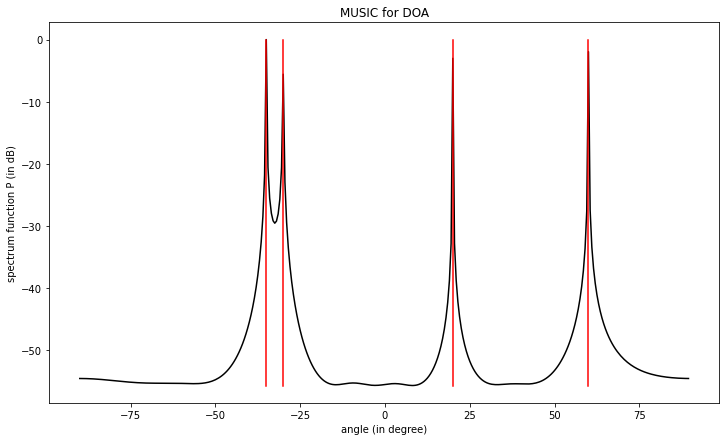

In [164]:
plt.figure(figsize=(12, 7))
plt.plot(peak_search_range, Pmusic, '-k')
plt.xlabel('angle (in degree)')
plt.ylabel('spectrum function P (in dB)')
plt.title('MUSIC for DOA')
for angle in angles:
        plt.plot((angle, angle), (Pmusic.min(), Pmusic.max()), 'r')
plt.savefig('images/basic_example.svg', format='svg')        
plt.show()

In [165]:
find_angles(Pmusic, peak_search_range, angles, prominence=10, width=1)

Actual angle(s) is/are: [20.0, 60.0, -30.0, -35.0]
Angle(s) found is/are: [-35. -30.  20.  60.]
4 / 4 correct guesses


array([-35., -30.,  20.,  60.])

We observe that in this basic scenario, the music algorithm is working as expected, giving very precise results.

### Comparison of results for correlated and uncorrelated data

Let's try now to test the basic algorithm in more realistic and complex scenarios, with correlated signals and angles that are close to each other:

In [99]:
true_angles = {"Wide Angles":[10, 40], 
              "Close Angles":[10, 15],}
frequencies = {"Uncorrelated Frequencies":[1/2, 1/5],
              "Correlated Frequencies 1/5":[1/5, 1/5]}#,
              #"Correlated Frequencies 1/2":[1/2, 1/2, 1/2]}

thetas = np.array(angles) / 180 * np.pi
N = 200
M = 10
var = 0.10         

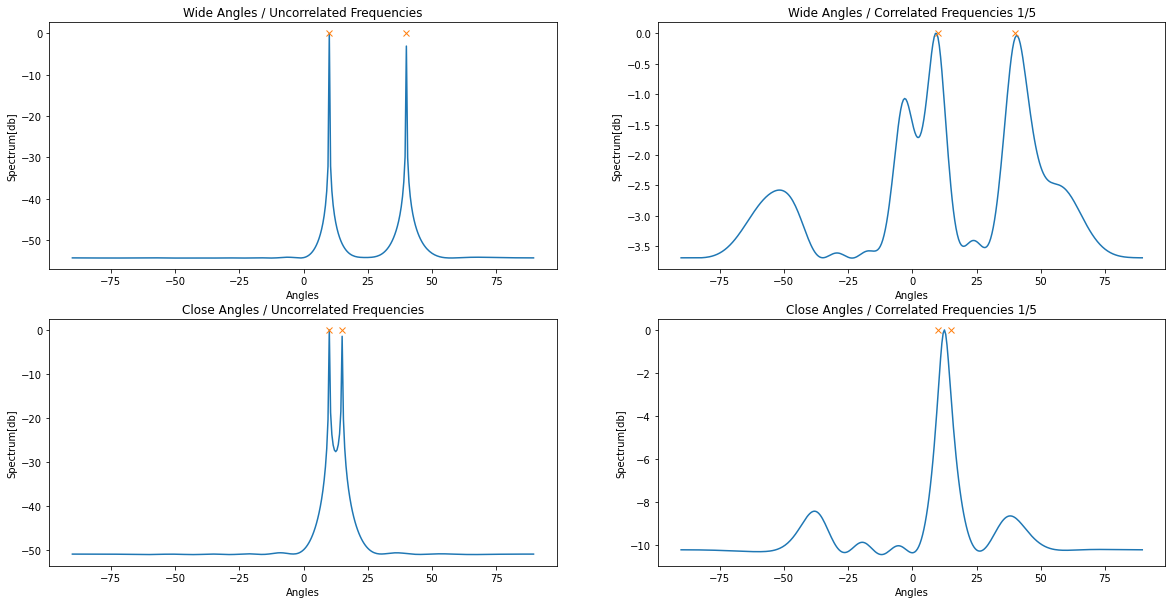

In [100]:
plt.figure(figsize=((20,10)))
index = 0
plotIndex = str(len(true_angles)) + str(len(frequencies)) + '1'
for i in true_angles.items():
    for j in frequencies.items():
        center_freq = max(j[1])
        wavelen = SPEED_OF_SOUND/center_freq
        d = wavelen / 2
        phase = (j[0][0:2]=="Co")
        X = generate_data(M, N, d, wavelen, i[1], j[1], var = var, phase = phase)
        Pmusic, angle_range = basic_musicDOA(X, M, d, wavelen, i[1])
        plt.subplot(int(plotIndex) + index)
        plt.plot(angle_range, Pmusic)
        plt.title((str(i[0]) + " / " + str(j[0])))
        plt.plot(i[1],(0,0),"x")
        plt.xlabel("Angles")
        plt.ylabel("Spectrum[db]")
        index += 1
plt.savefig('images/comparison_results_basic_gen.svg', format='svg')    
plt.show()

We observe that the basic algorthm gives very satisfying results for generated and uncorrelated data, even when the angles are close.
However, the quality of prediction of the angle is much more variable and mixed with the correlated data. In this case, an improved version of the Music Algorithm for DOA seems necessary.

(See the Simulations.py code for more examples and simulations, where diffrent tuning of parameters are tested)

# Improved MUSIC for DOA estimation

## 1 Introduction
The basic MUSIC algorithm considers all the feature vectors in the noise subspace. However, if the number of array elements is greater than the number of sources, the dimensionality of the noise subspace could be excessively large. In addition, the accuracy of the MUSIC algorithm will be affected when there are errors regarding array amplitude and phase, or when the input signal is correlated.

The improved MUSIC algorithm can solve these problems effectively.
First of all, the array steering vector is appropriately split, and then the subspace algorithm is applied to the DOA estimation. On the other hand, low-dimensional noise subspace is used in order to reduce the computational complexity. In this way DOA and irrelevant signals can be properly estimated, and array errors can also be partially mitigated.

This improved version of MUSIC is introduced in *DOA estimation based on the improved MUSIC algorithm (Dai and Du)* and *DOA estimation based on the MUSIC algorithm (Tang)*.

## 2 Improved MUSIC Algorithm

The signal steering vector $a(\theta)$ plays a very important role in the MUSIC algorithm. In fact, the accuracy of the improved version depends on the correct preprocessing of $a(\theta)$.

Firstly, the array steering vector $a(\theta)$ is divided into $a_1(\theta)$ and $a_2(\theta)$: $a_1(\theta)$ consists of the first M-L elements of $a(\theta)$, and $a_2(\theta)$ consists of the last L elements of $a(\theta)$.

Then let's consider $a(\theta)$ written in the following form: 

$$ a(\theta) = 
\begin{bmatrix}
a_1,_0(\theta) & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
a_1,_{K-1}(\theta) & 0 & \dots & 0 \\
0 & a_2,_0(\theta) & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & a_2,_{M-K-1}(\theta) \\
\end{bmatrix}
_{M\times(L+1)}
\begin{bmatrix}
1\\
1\\
\vdots \\
\vdots \\
1\\
1\\
\end{bmatrix}
_{(L+1)\times1} = \tilde{a}(\theta)\Gamma 
$$

The destination of arrival is estimated by

$$
\hat\theta = \mathop{\arg\max}_{\theta}\frac{1}{det[\tilde{a}^H(\theta) U_N U_N^H \tilde{a}(\theta) ]       }.       
$$    
$$(K = M - L \geqslant P+1)$$

Let us now implement the improved algorithm:<br>
(Note that it is already taking into account the correlated signal correction and the error estimation of the sensors, tackled in the next parts of this notebook)

In [166]:
def improved_musicDOA(X, M, d, wavelen, thetas, L=0, resscale="log", corr=False, ee=False):
    D = np.size(thetas)
    K=M-L
    
    # Make sure we have more receivers than input signals
    assert(M > D)
    
    # Peak search range (start degree, end degree, step)
    peak_search_range = np.arange(-90, 90, 0.5)
    
    # Center the output signal
    X_centered = (X.T - X.T.mean(axis=0)).T
    
    # Data covariance matrix: R = XX'
    R = np.dot(X_centered, X_centered.conj().T)
    
    # Improvement in case of correlation
    if corr:
        J = np.flip(np.eye(M), axis=1)
        R = R + np.dot(J, np.dot(R.conj(), J))

    # Eigen values decomposition of R
    eig_val, eig_vect = np.linalg.eig(R)
    
    # Find the smallest eigenvalues
    ids = np.abs(eig_val).argsort()[:(L+1)]  
    En = eig_vect[:,ids]
    
    # Noise subspace estimation: Ren = EnEn'
    Ren = np.dot(En, En.conj().T)
   
    # Size = future size of Pmusic
    Size = np.size(peak_search_range)

    m=np.arange(M)
    a=np.zeros((M,L+1))*1j
    Pmusic = np.zeros(Size)
    
    for i in range(Size):
        a[:K, 0] = np.exp(-1j*2*np.pi*d*np.sin(peak_search_range[i]*np.pi/180)/wavelen*m[:K])
        a[K:, 1:] = np.diag(np.exp(-1j*2*np.pi*d*np.sin(peak_search_range[i]*np.pi/180)/wavelen*m[K:]))
        Pmusic[i] = 1/abs(np.linalg.det(np.dot(a.conj().T, np.dot(Ren, a))))
        
    time=datetime.datetime.now()-starttime
    
    # Spatial spectrum function
    if resscale == "log":
        Pmusic = 10 * np.log10(Pmusic / np.max(Pmusic))    
    
    # Compute error estimation
    if ee:
        x=peak_search_range[np.argmax(Pmusic)]
        a[:K, 0] = np.exp(-1j*2*np.pi*d*np.sin(x*np.pi/180)/wavelen*m[:K])
        a[K:, 1:] = np.diag(np.exp(-1j*2*np.pi*d*np.sin(x*np.pi/180)/wavelen*m[K:]))
        n, v = np.linalg.eig(np.dot(a.conj().T, np.dot(Ren, a)))
        error = v[:, np.argsort(np.absolute(n))[0]]
        error = error / error[0]
        return Pmusic, peak_search_range, error
    
    return Pmusic, peak_search_range

## 3 Comparison between improved and basic algorithm

### Data setup

In [21]:
angles = np.array([20., 60.])
freqs = np.array([1/2, 1/3])
thetas = np.array(angles) / 180 * np.pi    
N = 200                         
M = 10                                            
center_freq = max(freqs)
wavelen = SPEED_OF_SOUND/center_freq
d = wavelen / 2                      
var = 0.01 

### 4.1 Execution speed
As introduced above, all the eigenvectors of the noise subspace are taken into account in MUSIC. When the number of microphones greatly exceeds the number of sources instead, choosing only some of the noise eigenvectors can lower the amount of computations.

Therefore, computing $U_N$ just requires the calculation of those eigenvectors corresponding to the L+1 smallest eigenvalues. This method reduces
the computational complexity. 

In [22]:
X = generate_data(M,N,d,wavelen,angles,freqs,var)

4845


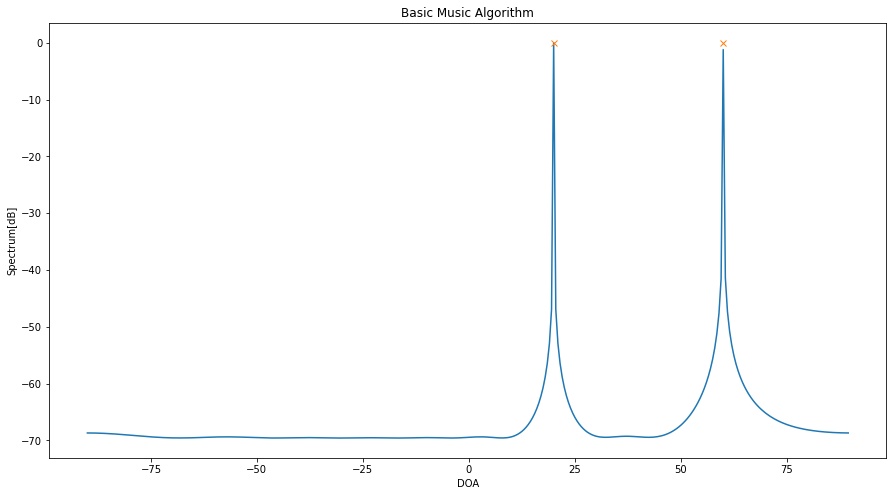

In [23]:
starttime = datetime.datetime.now()
Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen, thetas)
basictime=datetime.datetime.now()-starttime
plt.figure(figsize=(15,8))
plt.plot(peak_search_range, Pmusic)
plt.title("Basic Music Algorithm")
plt.plot(angles,np.zeros(angles.size),"x")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show
print(basictime.microseconds)

78337


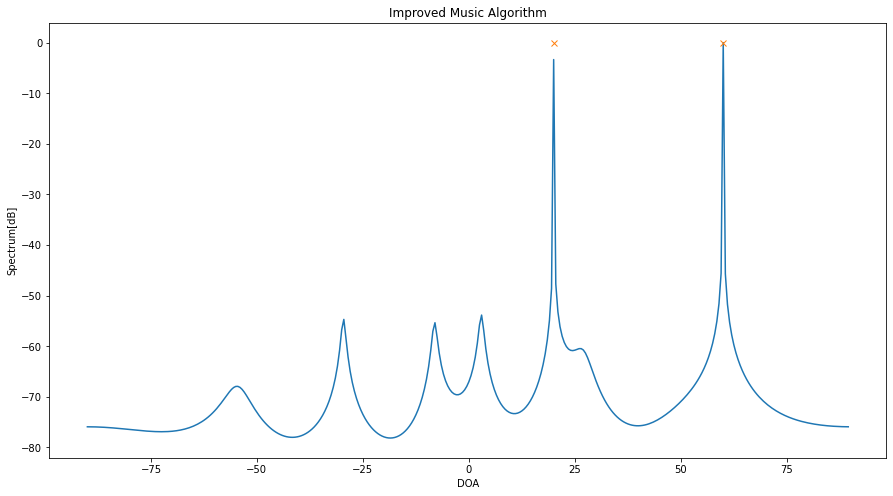

In [24]:
starttime = datetime.datetime.now()
Pmusic, peak_search_range= improved_musicDOA(X,M,d,wavelen,thetas,L=0)
improvedtime=datetime.datetime.now()-starttime
plt.figure(figsize=(15,8))
plt.plot(peak_search_range, Pmusic)
plt.title("Improved Music Algorithm")
plt.plot(angles,np.zeros(angles.size),"x")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show
print(improvedtime.microseconds)

### 4.2 Correlated signals
The application of the basic MUSIC algorithm is limited to uncorrelated signals. When the signal source is a correlated one, the estimation accuracy of the algorithm could be reduced or even completely lost. The improved MUSIC algorithm can solve this issue by adding the following:

Make a transformation matrix
$ J = 
\begin{bmatrix}
0 & \dots & 1  \\
\vdots&\ddots &\vdots\\
1 &\dots & 0  \\
\end{bmatrix}
$.


Let $Y = JX^*$, where $X^*$ is the complex conjugate of $X$. Then the covariance of the data matrix $Y$ is
 $$R_y = E[YY^H]=JRX^*J .$$

Construct the new matrix $R$ from the sum of $R_x$ and $R_y$:

$$R = R_x + R_y = 𝐴𝑅_𝑠𝐴^𝐻+J[𝐴𝑅_𝑠𝐴^𝐻]J^*+2𝜎2𝐼  .$$

The matrices $R_x$, $R_y$ and $R$ share the same noise subspace.

In order to perform eigen-decomposition of $R$ and to obtain the eigenvalues and eigenvectors of $R$ according to the estimated number of signal sources, the noise subspace is separated, and then this new noise subspace is used in the construction of the spatial spectrum. In the end the estimated DOA is obtained by finding the peak value.

In [76]:
angles=np.array([40, 80])
freqs=np.array([1/3, 1/3]) * np.pi 
thetas = np.array(angles) / 180 * np.pi 
N = 200                         
M = 10  
center_freq = max(freqs)
wavelen = 2*np.pi*SPEED_OF_SOUND/center_freq
d = wavelen / 2
var = 0.01 

X = generate_data(M,N,d,wavelen,angles,freqs,var, phase = True)

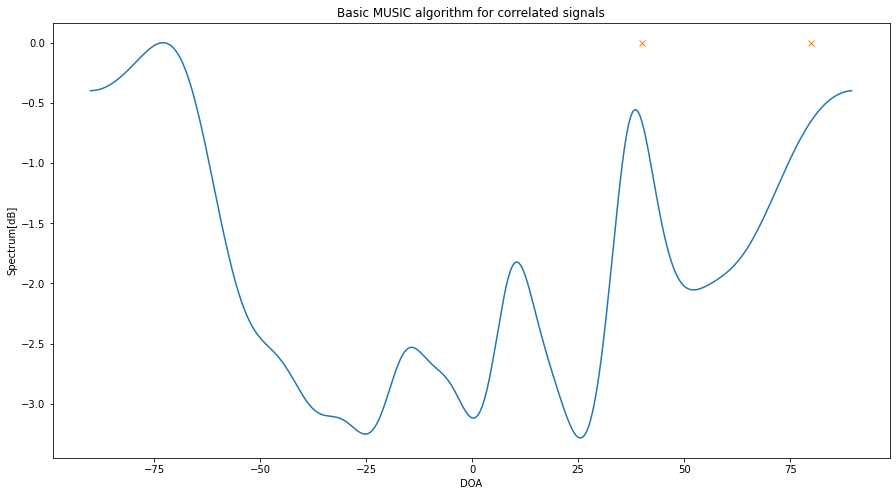

In [77]:
plt.figure(figsize=(15,8))
Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
plt.plot(peak_search_range, Pmusic)
plt.plot(angles,np.zeros(angles.size),"x")
plt.title("Basic MUSIC algorithm for correlated signals")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()

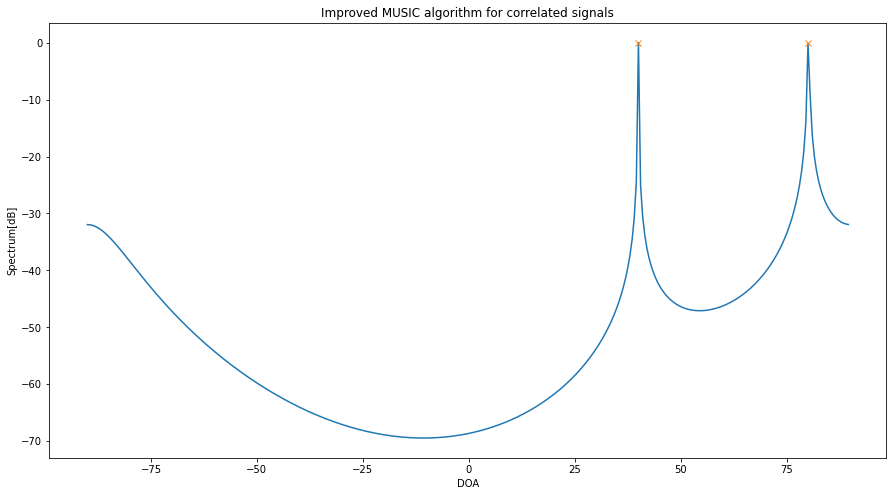

In [78]:
plt.figure(figsize=(15,8))
Pmusic, peak_search_range= improved_musicDOA(X,M,d,wavelen,thetas,corr="true",L=7)
plt.plot(peak_search_range, Pmusic)
plt.plot(angles,np.zeros(angles.size),"x")
plt.title("Improved MUSIC algorithm for correlated signals")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.show()

Let's try the previous comparison again with this improved algorithm:

In [105]:
true_angles = {"Wide Angles":[10, 40], 
              "Close Angles":[10, 15],}
frequencies = {"Uncorrelated Frequencies":[1/2, 1/5],
              "Correlated Frequencies 1/5":[1/5, 1/5]}#,
              #"Correlated Frequencies 1/2":[1/2, 1/2, 1/2]}

thetas = np.array(angles) / 180 * np.pi
N = 200
M = 10
var = 0.10         

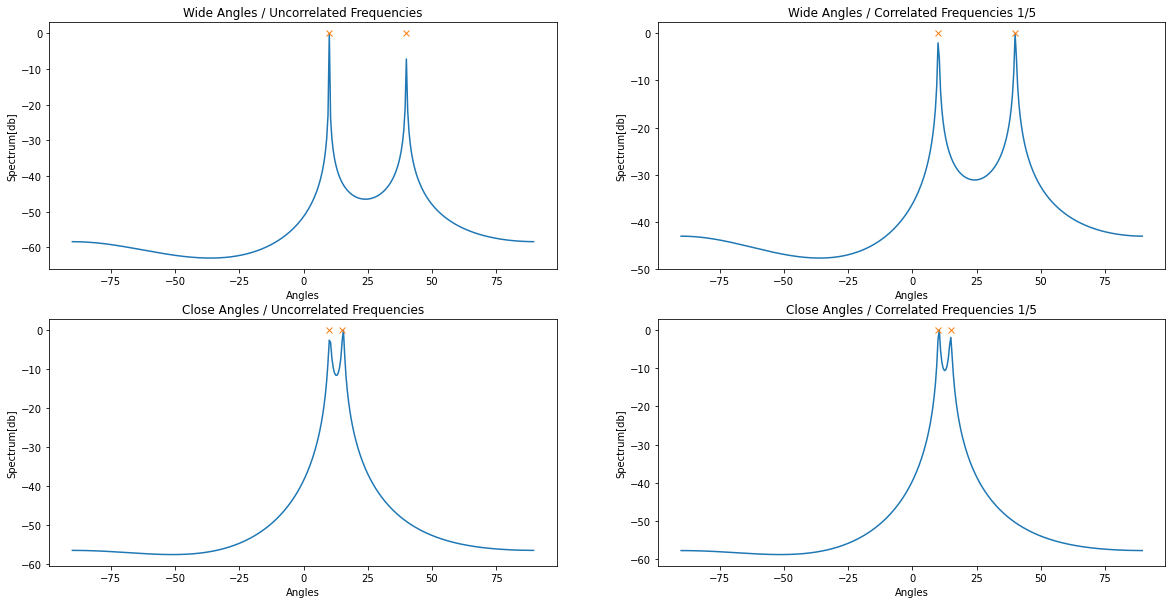

In [106]:
plt.figure(figsize=((20,10)))
index = 0
plotIndex = str(len(true_angles)) + str(len(frequencies)) + '1'
for i in true_angles.items():
    for j in frequencies.items():
        center_freq = max(j[1])
        wavelen = SPEED_OF_SOUND/center_freq
        d = wavelen / 2
        phase = (j[0][0:2]=="Co")
        X = generate_data(M,N,d,wavelen,i[1],j[1],var = var, phase = phase)
        starttime = datetime.datetime.now()
        if phase:
            Pmusic, peak_search_range= improved_musicDOA(X,M,d,wavelen,i[1],corr="true",L=7)
        else:
            Pmusic, peak_search_range= improved_musicDOA(X,M,d,wavelen,i[1],corr="false",L=7)
        plt.subplot(int(plotIndex) + index)
        plt.plot(angle_range, Pmusic)
        plt.title((str(i[0]) + " / " + str(j[0])))
        plt.plot(i[1],(0,0),"x")
        plt.xlabel("Angles")
        plt.ylabel("Spectrum[db]")
        index += 1
plt.savefig('images/comparison_results_improved_gen.svg', format='svg')    
plt.show()

### 4.3 The array amplitude-phase error estimation
When the last L elements in the steering vector are affected by array errors, the improved algorithm can still estimate the signal DOA, and can also estimate the corresponding array error.


$$ a'(\theta) = 
\begin{bmatrix}
a_1,_0(\theta) & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
a_1,_{K-1}(\theta) & 0 & \dots & 0 \\
0 & a_2,_0(\theta) & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & a_2,_{M-K-1}(\theta) \\
\end{bmatrix}
_{M\times(L+1)}
\begin{bmatrix}
1\\
\vdots \\
G1\\
G2\\
\vdots\\
GL\\
\end{bmatrix}
_{(L+1)\times1} = \tilde{a}'(\theta)\Gamma '
$$

Let's assume the L errors to be $G_1,...,G_L$. Since $\Gamma' \neq 0$, it is still possible to perform the DOA estimation. The array error estimation can be obtained by computing the eigenvector of the smallest eigenvalue, and the first element of $\Gamma'$ is 1.

In [141]:
angles = np.array([20., 60.])
freqs = np.array([1/2, 1/3])
thetas = np.array(angles) / 180 * np.pi    
N = 200                         
M = 10                                            
center_freq = max(freqs)
wavelen = SPEED_OF_SOUND/center_freq
d = wavelen / 2                      
var = 0.01 

X = generate_data(M,N,d,wavelen,angles,freqs,var)
L=4
phase_error = np.random.normal(0, np.pi/4, L)
amp_error = np.random.normal(1, 0.3, L)
X[-L:, :] = X[-L:, :] * np.tile(amp_error, (N, 1)).T * np.tile(np.exp(1j*phase_error), (N, 1)).T

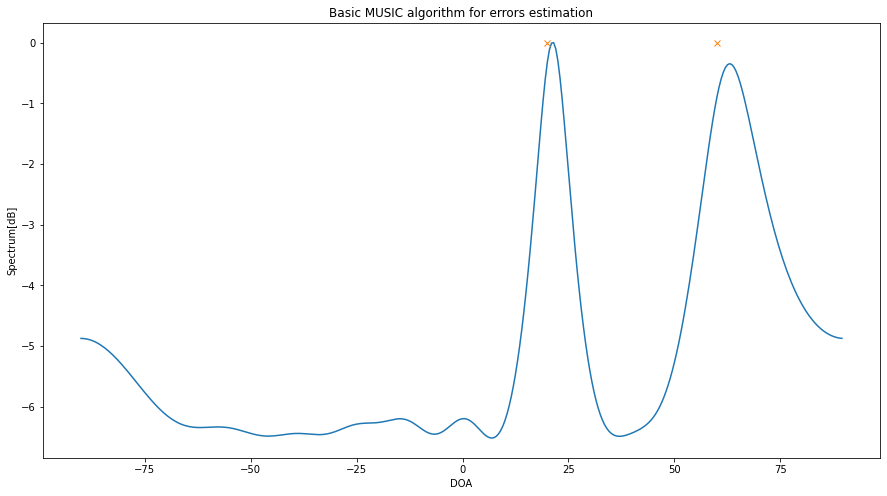

In [142]:
plt.figure(figsize=(15,8))
Pmusic, peak_search_range= basic_musicDOA(X,M,d,wavelen,thetas)
plt.plot(peak_search_range, Pmusic)
plt.plot(angles,np.zeros(angles.size),"x")
plt.title("Basic MUSIC algorithm for errors estimation")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.savefig('images/results_error_basic_gen.svg', format='svg')
plt.show()

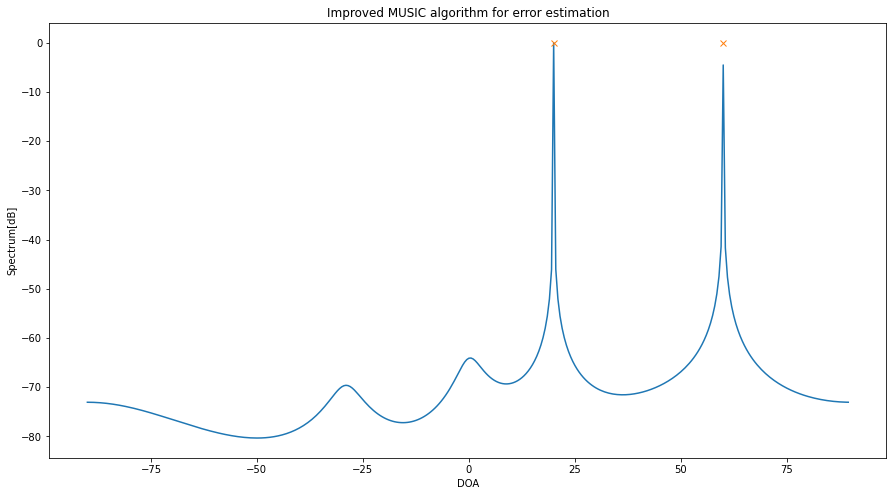

actual amplitude error:
1.3506
1.1182
0.9127
1.0675
estimated:
1.3475
1.1192
0.9126
1.0660

 actual phase error:
-0.5469
-0.0703
0.5658
-1.8715
estimated:
-0.5481
-0.0706
0.5660
-1.8745


In [143]:
Pmusic, peak_search_range, error= improved_musicDOA(X,M,d,wavelen,thetas,L, ee="true")
plt.figure(figsize=(15,8))
plt.plot(peak_search_range, Pmusic)
plt.plot(angles,np.zeros(angles.size),"x")
plt.title("Improved MUSIC algorithm for error estimation")
plt.xlabel("DOA")
plt.ylabel("Spectrum[dB]")
plt.savefig('images/results_error_impro_gen.svg', format='svg')
plt.show()


amp_error_estimation = np.absolute(error)
phase_error_estimation = np.angle(error)

print('actual amplitude error:')
for x in amp_error.tolist():print('%.4f' % x)

print('estimated:')
for x in amp_error_estimation.tolist()[1:]:print('%.4f' % x)

print('\n actual phase error:')
for x in phase_error.tolist():print('%.4f' % x)

print('estimated:')
for x in phase_error_estimation.tolist()[1:]:print('%.4f' % x)